### Importing required packages 

In [1]:
import os,sys
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.io
import numpy as np 
from scipy.spatial.distance import pdist
import time 
import math
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential

Using TensorFlow backend.
/Users/Qiqi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Qiqi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Qiqi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Qiqi/opt/anaconda3/lib/python3.7/site-pa

In [2]:
from keras.layers import Dense, Activation, Flatten, Input, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam

### loading data 

In [3]:
# change the root to your own path 
root = sys.path[0]
train_dir =  os.path.join(root,  '../data/train_set')  
train_image_dir =  os.path.join(train_dir, 'images')
train_pt_dir =  os.path.join(train_dir, 'points' )
train_label_path =  os.path.join(train_dir,  "label.csv") 

In [4]:
info = pd.read_csv(train_label_path)
train_idx, test_idx = train_test_split(info['Index'], test_size=0.2, random_state=123)

# read mat file and store coordinates in mat 
m = []
for idx in info['Index']: 
    file = "%04d.mat"%(idx)
    m.append( scipy.io.loadmat( os.path.join( train_pt_dir, file ) ))

mat = [x[[i for i in x.keys() if not i in ['__header__', '__version__', '__globals__']][0]] for x in m]

###  train test split

In [5]:
train_idx, test_idx = train_test_split(info['Index'], test_size=0.2, random_state=123)

In [6]:
train_mat = [ mat[i-1] for i in train_idx ] 
test_mat = [ mat[i-1] for i in test_idx ] 

In [7]:
train_labels = info.emotion_idx[train_idx-1]
test_labels = info.emotion_idx[test_idx-1]

In [8]:
train_label_cat = to_categorical(train_labels)
train_label_cat= train_label_cat[:,1:]
test_label_cat = to_categorical(test_labels)
test_label_cat= test_label_cat[:,1:]

### feature extraction  

In [9]:
# method 1：  pairwise_dist_cal  
#def pairwise_dist_cal(xy_cord):
    #p_dist =[]
    #for i in range(xy_cord.shape[0]):
        #for j in range(i+1,xy_cord.shape[0]):
               # p_dist.append( abs(round(xy_cord[i,0]) - round(xy_cord[j,0] )) )
               # p_dist.append( abs(round(xy_cord[i,1]) - round(xy_cord[j,1] ) ) )
    #return p_dist 



#### updated methods with selected fiducial points; this reduce 78 poins to 50  
''' 
feature selection : 1. remove  points P64 - 70 and P72 - 78  
                 2. remove P51,53,55,57,58,60, 61, 63
                 3. calculate midpints between  upper and lower eyebrow lines and replace P20-22,P24-16 with midpoints               
So there is in total 50 points left, which gives 50*49 pairwise distance 
'''

def pairwise_dist_cal_updt(mt):
    t0 = time.time()
    p_dist_updt =np.zeros([len(mt),1225,2])
    n = len(mt)
    for k in range(n):
        xy_cord = mt[k]

        xy_cord_cpy  = xy_cord
        
        #  eye_brow midpoint 
        to_add_brl = (xy_cord_cpy[19:22]+ xy_cord_cpy[23:26])/2
        to_add_brr = (xy_cord_cpy[27:30]+ xy_cord_cpy[31:34])/2

        # index to remove 
        rm_idx = np.append(np.arange(63,70), np.arange(71,78))
        rm_idx = np.append(rm_idx,np.arange(50,57,2) )
        rm_idx = np.append(rm_idx, [57,59,60,62])
        rm_idx = np.append(rm_idx, np.arange(19,22))
        rm_idx = np.append(rm_idx, np.arange(23,26))
        rm_idx = np.append(rm_idx, np.arange(27,30))
        rm_idx = np.append(rm_idx, np.arange(31,34))
        xy_cord = np.delete(xy_cord, rm_idx, axis = 0) 
        xy_cord = np.concatenate((xy_cord,to_add_brl,to_add_brr))
        

        dist_h = [] 
        dist_v = []
        for i in range(xy_cord.shape[0]):
            for j in range(i+1,xy_cord.shape[0]):
                dist_h.append( abs(round(xy_cord[i,0]) - round(xy_cord[j,0] )) )
                dist_v.append( abs(round(xy_cord[i,1]) - round(xy_cord[j,1] ) ) )
        p_dist_updt[k,:,0]= dist_h
        p_dist_updt[k,:,1]= dist_v
    

    print("feature constructions takes %s seconds" % (time.time() - t0))
    return p_dist_updt.reshape([n,2450])


In [10]:
print("training: ")
train_data = pairwise_dist_cal_updt(train_mat[0:])

training: 
feature constructions takes 19.490326166152954 seconds


In [11]:
print("testing: ")
test_data = pairwise_dist_cal_updt(test_mat[0:])

testing: 
feature constructions takes 4.743052959442139 seconds


### XGB

In [12]:
from xgboost.sklearn import XGBClassifier

In [13]:
train_labels_xgb = [ x  - 1 for x in train_labels ] 
test_labels_xgb = [ x  - 1 for x in test_labels ] 

In [30]:
xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators= 200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',  # for multi-labels classification 
 num_class = 22, 
 scale_pos_weight=1,
 seed=123)
start_time=time.time()
xgb.fit(train_data, train_labels_xgb ,eval_metric='auc')
print("training  model takes %s seconds" % round((time.time() - start_time),3))

training  model takes 1156.417 seconds


In [31]:
start_time = time.time()
pred_xgb = xgb.predict(test_data)
print("testing model takes %s seconds" % round((time.time() - start_time),3))

testing model takes 1.199 seconds


In [32]:
acc_xgb = accuracy_score(pred_xgb,test_labels_xgb )
print("Test accuracy is %s percent" %(acc_xgb*100))

Test accuracy is 47.4 percent


Try other leaner rate and n_trees

In [33]:
xgb_2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators= 500,
 max_depth= 3 ,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',  # for multi-labels classification 
 num_class = 22, 
 scale_pos_weight=1,
 seed=123)

In [34]:
start_time = time.time()
xgb_2.fit(train_data, train_labels_xgb ,eval_metric='auc')
print("training  model takes %s seconds" % round((time.time() - start_time),3))

training  model takes 2236.248 seconds


In [40]:
pred_xgb_2_train = xgb_2.predict(train_data)
acc_2_train = accuracy_score(pred_xgb_2_train,train_labels_xgb )
print("Train accuracy is %s percent" %(acc_2_train *100))

Train accuracy is 98.15 percent


In [41]:
start_time = time.time()
pred_xgb_2 = xgb_2.predict(test_data)
print("Testing model takes %s seconds" % round((time.time() - start_time),3))

Testing model takes 2.033 seconds


In [42]:
acc_2_test = accuracy_score(pred_xgb_2,test_labels_xgb )
print("Test accuracy is %s percent" %(acc_2_test *100))

Test accuracy is 49.2 percent


Since XGB doesn't improve that much. We deceided to try other models, like Neural Network 

### Neural Network 

In [14]:
X = train_data
Y = train_label_cat

#####  first model

In [15]:
input_shape = [2450] 
input_layer = Input(input_shape)
x = BatchNormalization()(input_layer) 
x = Dense(22*20,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x) 
x = Dense(22*10,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
x = Dropout(0.25)(x)
x = Dense(22*6,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
x = Dropout(0.25)(x)
x = Dense(22*2,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
output_layer = Dense(22,activation='softmax',kernel_initializer=initializers.glorot_normal(seed=4))(x) 
model = Model(input_layer,output_layer)


Epoch 1/100
2000/2000 [==============================] - 3s 1ms/step - loss: 3.0098 - accuracy: 0.1100
Epoch 2/100
2000/2000 [==============================] - 2s 1ms/step - loss: 2.6026 - accuracy: 0.1940
Epoch 3/100
2000/2000 [==============================] - 2s 1ms/step - loss: 2.3021 - accuracy: 0.2700
Epoch 4/100
2000/2000 [==============================] - 2s 1ms/step - loss: 2.1436 - accuracy: 0.2975
Epoch 5/100
2000/2000 [==============================] - 2s 1ms/step - loss: 1.9974 - accuracy: 0.3440
Epoch 6/100
2000/2000 [==============================] - 2s 1ms/step - loss: 1.8468 - accuracy: 0.3920
Epoch 7/100
2000/2000 [==============================] - 2s 1ms/step - loss: 1.8075 - accuracy: 0.4035
Epoch 8/100
2000/2000 [==============================] - 2s 1ms/step - loss: 1.6632 - accuracy: 0.4440
Epoch 9/100
2000/2000 [==============================] - 2s 1ms/step - loss: 1.6180 - accuracy: 0.4590
Epoch 10/100
2000/2000 [==============================] - 2s 981us/step 

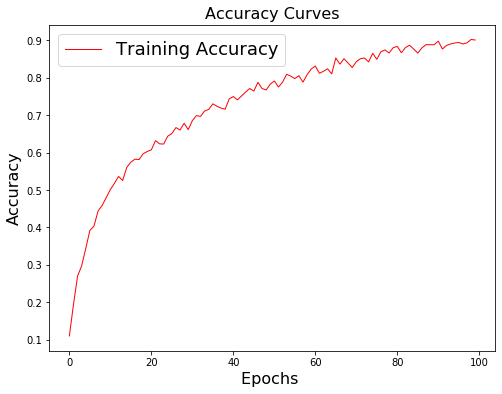

In [16]:
start_time = time.time()
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model_his = model.fit(X,Y,epochs=100)
plt.figure(figsize=[8,6])
plt.plot(model_his.history['accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
print("training  model takes %s seconds" % round((time.time() - start_time),3))

In [45]:
t0 = time.time()
pred = model.predict(test_data)
pred_lst = [] 
for i in range(len(pred)):
    arr = pred[i]
    idx = np.argwhere(arr == np.max(arr))
    pred_lst.append(idx[0][0])
tst_labl = np.argmax(test_label_cat, axis=-1)
acc = accuracy_score(pred_lst, tst_labl)
print("Test accuracy is %s percent" % round(acc*100,3))
print("testing model takes %s seconds" % round((time.time() - t0),3))

Test accuracy is 53.6 percent
testing model takes 0.144 seconds


#####  second model  

In [18]:
input_shape = [2450] 
input_layer = Input(input_shape)
x = BatchNormalization(momentum = 0.88)(input_layer) 
x = Dense(22*10,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x) 
x = Dense(22*8,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
x = Dropout(0.25)(x)
x = Dense(22*4,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
x = Dropout(0.25)(x)
x = Dense(22*2,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
output_layer = Dense(22,activation='softmax',kernel_initializer=initializers.glorot_normal(seed=4))(x) 
model2 = Model(input_layer,output_layer)

Epoch 1/100
2000/2000 [==============================] - 1s 690us/step - loss: 3.0590 - accuracy: 0.0815
Epoch 2/100
2000/2000 [==============================] - 1s 399us/step - loss: 2.7153 - accuracy: 0.1690
Epoch 3/100
2000/2000 [==============================] - 1s 413us/step - loss: 2.3441 - accuracy: 0.2405
Epoch 4/100
2000/2000 [==============================] - 1s 409us/step - loss: 2.1477 - accuracy: 0.2965
Epoch 5/100
2000/2000 [==============================] - 1s 445us/step - loss: 1.9895 - accuracy: 0.3360
Epoch 6/100
2000/2000 [==============================] - 1s 415us/step - loss: 1.8939 - accuracy: 0.3710
Epoch 7/100
2000/2000 [==============================] - 1s 399us/step - loss: 1.8041 - accuracy: 0.3915
Epoch 8/100
2000/2000 [==============================] - 1s 399us/step - loss: 1.7150 - accuracy: 0.4380
Epoch 9/100
2000/2000 [==============================] - 1s 395us/step - loss: 1.6383 - accuracy: 0.4565
Epoch 10/100
2000/2000 [==============================]

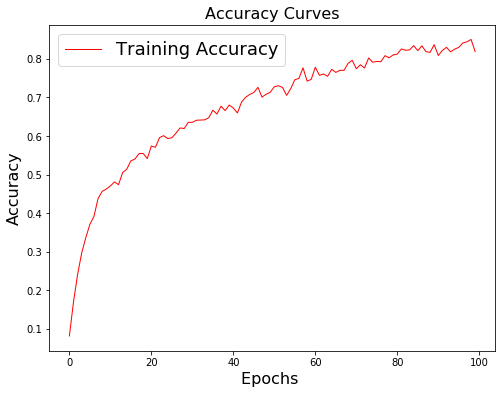

In [19]:
start_time = time.time()
model2.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model_his = model2.fit(X,Y,epochs=100)
plt.figure(figsize=[8,6])
plt.plot(model_his.history['accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
print("training  model takes %s seconds" % round((time.time() - start_time),3))

In [43]:
t0 = time.time()
pred2 = model2.predict(test_data)
pred_lst2 = [] 
for i in range(len(pred2)):
    arr = pred2[i]
    idx = np.argwhere(arr == np.max(arr))
    pred_lst2.append(idx[0][0])
tst_labl = np.argmax(test_label_cat, axis=-1)
acc = accuracy_score(pred_lst2, tst_labl)
print("Test accuracy is %s percent" % round(acc*100,3))
print("testing model takes %s seconds" % round((time.time() - t0),3))

Test accuracy is 56.4 percent
testing model takes 0.179 seconds


#####  third model 

In [21]:
input_shape = [2450] 
input_layer = Input(input_shape)
x = BatchNormalization(momentum = 0.88)(input_layer) 
x = Dense(22*20,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x) 
x = Dense(22*10,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
x = Dropout(0.25)(x)
x = Dense(22*6,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
x = Dropout(0.25)(x)
x = Dense(22*2,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
output_layer = Dense(22,activation='softmax',kernel_initializer=initializers.glorot_normal(seed=4))(x) 
model3 = Model(input_layer,output_layer)

Epoch 1/100
2000/2000 [==============================] - 2s 1ms/step - loss: 2.9908 - accuracy: 0.0975
Epoch 2/100
2000/2000 [==============================] - 1s 750us/step - loss: 2.6035 - accuracy: 0.2020
Epoch 3/100
2000/2000 [==============================] - 2s 1ms/step - loss: 2.2965 - accuracy: 0.2825
Epoch 4/100
2000/2000 [==============================] - 2s 1ms/step - loss: 2.0985 - accuracy: 0.3215
Epoch 5/100
2000/2000 [==============================] - 3s 1ms/step - loss: 1.9475 - accuracy: 0.3640
Epoch 6/100
2000/2000 [==============================] - 2s 1ms/step - loss: 1.8338 - accuracy: 0.3995
Epoch 7/100
2000/2000 [==============================] - 4s 2ms/step - loss: 1.7790 - accuracy: 0.4050
Epoch 8/100
2000/2000 [==============================] - 3s 1ms/step - loss: 1.6514 - accuracy: 0.4510
Epoch 9/100
2000/2000 [==============================] - 3s 1ms/step - loss: 1.5575 - accuracy: 0.4695
Epoch 10/100
2000/2000 [==============================] - 3s 1ms/step -

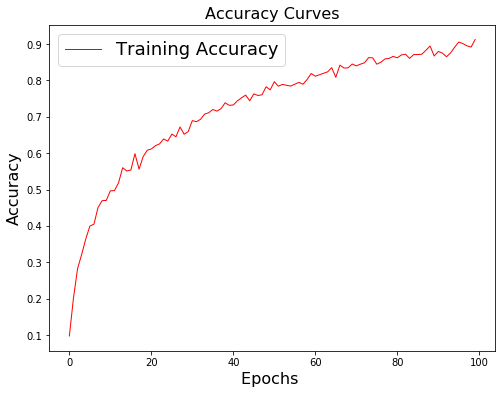

In [22]:
start_time = time.time()
model3.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model_his = model3.fit(X,Y,epochs=100)
plt.figure(figsize=[8,6])
plt.plot(model_his.history['accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
print("training  model takes %s seconds" % round((time.time() - start_time),3))

In [44]:
t0 = time.time()
pred3 = model3.predict(test_data)
pred_lst3 = [] 
for i in range(len(pred3)):
    arr = pred3[i]
    idx = np.argwhere(arr == np.max(arr))
    pred_lst3.append(idx[0][0])
tst_labl = np.argmax(test_label_cat, axis=-1)

acc = accuracy_score(pred_lst3, tst_labl)
print("Test accuracy is %s percent" %round(acc*100,3))
print("testing model takes %s seconds" % round((time.time() - t0),3))

Test accuracy is 55.6 percent
testing model takes 0.17 seconds


Since second model gives the highest test accuary among three, so deceides to use this on the presentation day. 

### Run the testing data  -  using model2 in NN 

In [24]:
tst_root = sys.path[0]
test_dir = os.path.join(tst_root,  '../data/test_set_sec2')  
test_path =  os.path.join(test_dir,  "labels_prediction.csv") 
test_index = pd.read_csv(test_path)
test_pt_dir =  os.path.join(test_dir, 'points' )

In [25]:
# read mat file and store coordinates in mat 
m_test = []
for idx in test_index['Index']: 
    file = "%04d.mat"%(idx)
    m_test.append( scipy.io.loadmat( os.path.join( test_pt_dir, file ) ))

In [26]:
mat_test = [x[[i for i in x.keys() if not i in ['__header__', '__version__', '__globals__']][0]] for x in m_test]

In [27]:
to_test_data = pairwise_dist_cal_updt(mat_test)
# choose model2 

feature constructions takes 30.239994049072266 seconds


In [28]:
t0 = time.time()
pred_test  = model2.predict(to_test_data)
pred_test_lst = [] 
for i in range(len(pred_test)):
    arr = pred_test[i]
    idx = np.argwhere(arr == np.max(arr))
    pred_test_lst.append(idx[0][0])
print("testing model takes %s seconds" % round((time.time() - t0),3))

testing model takes 0.315 seconds


In [29]:
final_pred = pd.DataFrame([1+x for x in pred_test_lst]).to_csv("../output/final_model.csv",index=False)